In [1]:
import keras
import random
import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Input, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam, Nadam
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
np.random.seed(42) # NumPy
random.seed(42) # Python
tf.random.set_seed(42) # Tensorflow

In [3]:
from imblearn.over_sampling import SMOTE

In [4]:
train_data = pd.read_pickle('final_train_data.pkl')

In [6]:
# Feature selection
X = train_data.drop(['isFraud'], axis=1)
y = train_data['isFraud']
# split the data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)


In [7]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(X_train_smote.shape)
print(y_train_smote.shape)

(911646, 171)
(911646,)


In [8]:
y_train_smote.value_counts(normalize=True)

isFraud
0    0.5
1    0.5
Name: proportion, dtype: float64

In [9]:
K.clear_session()

In [10]:
# create a checkpoint callback to save model based on validation recall values
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_callback = ModelCheckpoint(
    filepath="./baseline_model_smote/base_model_v1_epoch_{epoch:02d}_recall{val_recall:.2f}_auc{val_auc:.2f}_checkpoint.h5",
    monitor="val_recall",
    mode="max",
    save_best_only=True,
    verbose=1
)

# create earlystopping callback based on val_recall
early_stopping_callback = EarlyStopping(monitor="val_recall", mode="max", patience=10)


# create reduce lr on plateau callback
reduce_lr = ReduceLROnPlateau(monitor="val_recall", mode="max", patience=5, verbose=1, factor=0.1)
# create a callback list
callbacks = [checkpoint_callback, early_stopping_callback, reduce_lr]

# create model function

def create_baseline_model(optimizer):
    # Create a baseline ANN model using keras for predicting binary classes of fraud
    # define ANN model
    model = keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=[X_train_smote.shape[1]]),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # add recall and auc as metrics
    recall = tf.keras.metrics.Recall(name='recall')
    auc = tf.keras.metrics.AUC(name='auc')

    # compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[recall, auc])

    return model


In [11]:
# choose adam as optimizer
from keras.optimizers import Adam
adam = Adam(learning_rate=0.003)
model = create_baseline_model(adam)
history = model.fit(X_train_smote, y_train_smote, epochs=50, batch_size=512, validation_data=(X_val, y_val), verbose=1, callbacks=callbacks)

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Epoch 1/50


2023-05-27 12:51:08.963913: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1781/1781 [==============================] - ETA: 0s - loss: 3.6159 - recall: 0.6734 - auc: 0.7550
Epoch 1: val_recall improved from -inf to 0.70646, saving model to ./baseline_model_smote/base_model_v1_epoch_01_recall0.71_auc0.83_checkpoint.h5
1781/1781 [==============================] - 82s 44ms/step - loss: 3.6159 - recall: 0.6734 - auc: 0.7550 - val_loss: 0.4915 - val_recall: 0.7065 - val_auc: 0.8338 - lr: 0.0030
Epoch 2/50
1781/1781 [==============================] - ETA: 0s - loss: 0.4715 - recall: 0.7550 - auc: 0.8558
Epoch 2: val_recall did not improve from 0.70646
1781/1781 [==============================] - 18s 10ms/step - loss: 0.4715 - recall: 0.7550 - auc: 0.8558 - val_loss: 0.3587 - val_recall: 0.5957 - val_auc: 0.8394 - lr: 0.0030
Epoch 3/50
1777/1781 [============================>.] - ETA: 0s - loss: 0.4398 - recall: 0.7723 - auc: 0.8769
Epoch 3: val_recall did not improve from 0.70646
1781/1781 [==============================] - 17s 10ms/step - loss: 0.4398 - recall: 0

In [11]:
model = keras.models.load_model('baseline_model_smote/base_model_v1_epoch_04_recall0.72_auc0.85_checkpoint.h5')

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [12]:
from sklearn.metrics import confusion_matrix

In [13]:
# tensorflow model prediction
y_pred = model.predict(X_val)
y_pred_binary = np.round(y_pred).flatten()
cm = confusion_matrix(y_val, y_pred_binary)

2023-05-27 23:10:42.649341: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3691/3691 [==============================] - 5s 1ms/step


In [14]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

[Text(0, 0.5, 'Non Fraud'), Text(0, 1.5, 'Fraud')]

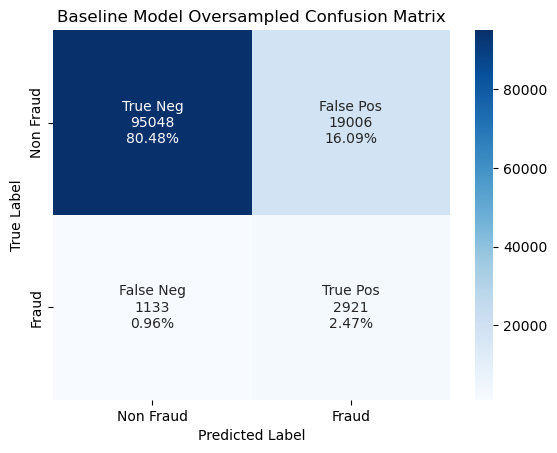

In [17]:
fig, ax = plt.subplots()
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
plt.title("Baseline Model Oversampled Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
ax.xaxis.set_ticklabels(['Non Fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Non Fraud', 'Fraud'])

In [28]:
temp = X_val.copy()
temp['predicted'] = y_pred
temp['true'] = y_val
fraud_cases = temp[temp['true'] == 1]
non_fraud_cases = temp[temp['true']==0]

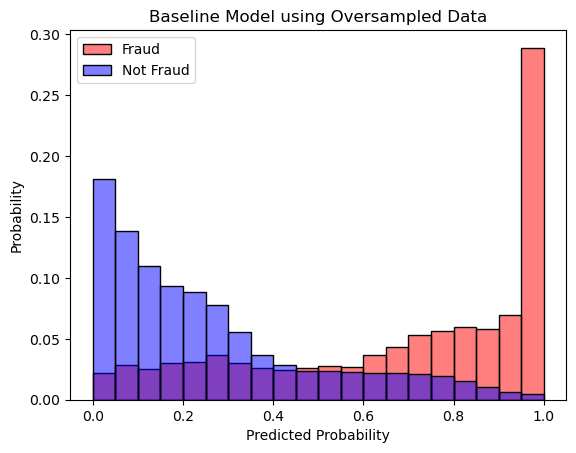

In [30]:
fig, ax = plt.subplots()
sns.histplot(data=fraud_cases, x='predicted', binwidth=0.05, binrange=[0,1], stat='probability', color='red', alpha=0.5, label='Fraud')
sns.histplot(data=non_fraud_cases, x='predicted', binwidth=0.05, binrange=[0,1], stat='probability', color='blue', alpha=0.5, label='Not Fraud')
plt.title("Baseline Model using Oversampled Data")
plt.xlabel("Predicted Probability")
ax.legend()
plt.show()

In [27]:
y_val.value_counts(normalize=True)

isFraud
0    0.965675
1    0.034325
Name: proportion, dtype: float64

In [18]:
from sklearn.metrics import auc, roc_curve
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1 = (2 * recall * precision) / (recall + precision)
y_pred_keras = y_pred.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

print(f"False Positive Rate: {fpr}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"F1: {f1}")
print(f"AUC: {auc_keras}")

False Positive Rate: 0.1666403633366651
Recall: 0.7205229403058707
Precision: 0.13321475806083824
Accuracy: 0.8294865716124226
F1: 0.22485662599592007
AUC: 0.8521113967609784


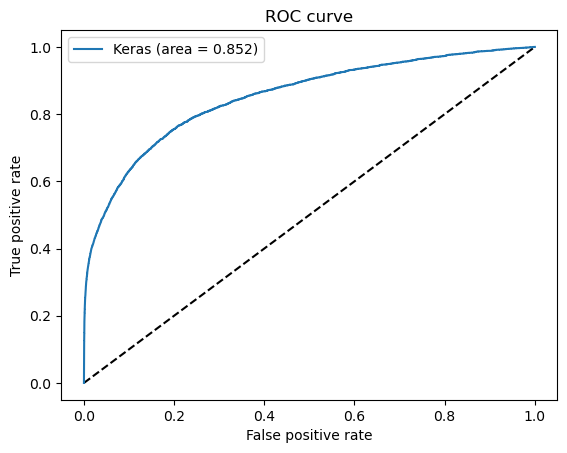

In [19]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

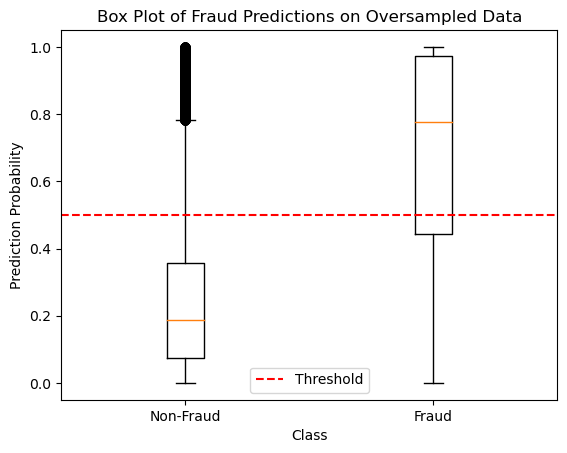

In [32]:
fraud_cases = y_pred[y_val==1]
non_fraud_cases = y_pred[y_val==0]
threshold = 0.5
plt.boxplot([non_fraud_cases.flatten(), fraud_cases.flatten()])
plt.xticks([1, 2], ['Non-Fraud', 'Fraud'])
plt.ylabel('Prediction Probability')
plt.xlabel('Class')
plt.title('Box Plot of Fraud Predictions on Oversampled Data')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()